In [2]:
import torch
from tensordict.nn import TensorDictModule, TensorDictSequential
import time
from torchrl.envs import GymEnv, StepCounter, TransformedEnv


torch.manual_seed(0)

env = TransformedEnv(GymEnv("CartPole-v1"), StepCounter())
env.set_seed(0)

ImportError: RuntimeError: TorchRL does not support gymnasium 1.0 or later versions due to incompatible
changes in the Gym API.
Using gymnasium 1.0 with TorchRL would require significant modifications to your code and may result in:
* Inaccurate step counting, as the auto-reset feature can cause unpredictable numbers of steps to be executed.
* Potential data corruption, as the environment may require/produce garbage data during reset steps.
* Trajectory overlap during data collection.
* Increased computational overhead, as the library would need to handle the additional complexity of auto-resets.
* Manual filtering and boilerplate code to mitigate these issues, which would compromise the modularity and ease of
use of TorchRL.
To maintain the integrity and efficiency of our library, we cannot support this version of gymnasium at this time.
If you need to use gymnasium 1.0 or later, we recommend exploring alternative solutions or waiting for future updates
to TorchRL and gymnasium that may address this compatibility issue.
For more information, please refer to discussion https://github.com/pytorch/rl/discussions/2483 in torchrl.


In [3]:
from torchrl.modules import EGreedyModule, MLP, QValueModule


value_mlp = MLP(out_features=env.action_spec.shape[-1], num_cells=[64, 64])
value_net = TensorDictModule(
    value_mlp, in_keys=["observation"], out_keys=["action_value"]
)

policy = TensorDictSequential(value_net, QValueModule(spec=env.action_spec))
exploration_module = EGreedyModule(env.action_spec, annealing_num_steps=10_000, eps_init=0.5)
policy_explore = TensorDictSequential(policy, exploration_module)

In [4]:
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torch.optim import Adam

init_rand_steps = 5_000
frames_per_batch = 100
optim_steps = 10

collector = SyncDataCollector(
    env,
    policy_explore,
    frames_per_batch=frames_per_batch,
    total_frames=-1,
    init_random_frames=init_rand_steps
)

rb = ReplayBuffer(storage=LazyTensorStorage(10_000))

In [5]:
from torchrl.objectives import DQNLoss, SoftUpdate

loss = DQNLoss(value_network=policy, action_space=env.action_spec, delay_value=True)
optim = Adam(loss.parameters(), lr=0.02)
updater = SoftUpdate(loss, eps=0.99)

In [7]:
from torchrl._utils import logger as torchrl_logger
from torchrl.record import CSVLogger, VideoRecorder

path = "./training_loop"
logger = CSVLogger(exp_name="dqn", log_dir=path, video_format="mp4")
video_recorder = VideoRecorder(logger, tag="video")
record_env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True, pixels_only=False), video_recorder
)

In [8]:
total_count = 0
total_episodes = 0
t0 = time.time()
for i, data in enumerate(collector):
    # Write data in replay buffer
    rb.extend(data)
    max_length = rb[:]["next", "step_count"].max()
    if len(rb) > init_rand_steps:
        # Optim loop (we do several optim steps
        # per batch collected for efficiency)
        for _ in range(optim_steps):
            sample = rb.sample(128)
            loss_vals = loss(sample)
            loss_vals["loss"].backward()
            optim.step()
            optim.zero_grad()
            # Update exploration factor
            exploration_module.step(data.numel())
            # Update target params
            updater.step()
            if i % 10:
                torchrl_logger.info(f"Max num steps: {max_length}, rb length {len(rb)}")
            total_count += data.numel()
            total_episodes += data["next", "done"].sum()
    if max_length > 200:
        break

t1 = time.time()

torchrl_logger.info(
    f"solved after {total_count} steps, {total_episodes} episodes and in {t1-t0}s."
)

2024-11-18 09:21:57,637 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,647 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,658 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,670 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,684 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,696 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,708 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,720 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,741 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,755 [torchrl][INFO] Max num steps: 100, rb length 5200
2024-11-18 09:21:57,915 [torchrl][INFO] Max num steps: 100, rb length 5300
2024-11-18 09:21:57,925 [torchrl][INFO] Max num steps: 100, rb length 5300
2024-11-18 09:21:57,937 [torchrl][INFO] Max num steps: 100, rb length 5300
2024-11-18 09:21:57,950 [

Episode 100, Average Reward (last 100): 0.28
Episode 200, Average Reward (last 100): 9.30
Episode 300, Average Reward (last 100): 7.50
Episode 400, Average Reward (last 100): 7.25
Episode 500, Average Reward (last 100): 4.88
Episode 600, Average Reward (last 100): 4.90
Episode 700, Average Reward (last 100): 6.98
Episode 800, Average Reward (last 100): 9.93
Episode 900, Average Reward (last 100): 2.18
Episode 1000, Average Reward (last 100): 10.42


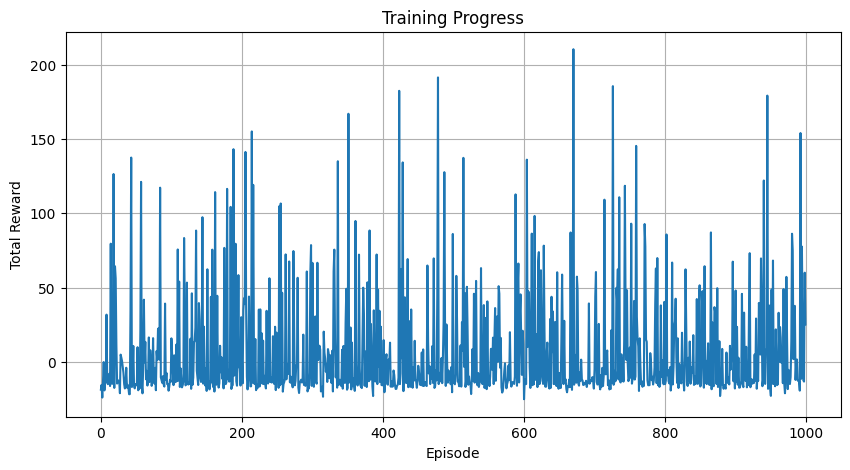

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


class GridWorldEnv(gym.Env):
    """
    Multi-agent grid world environment where agents need to reach their goal positions
    while avoiding collisions with other agents.
    """

    def __init__(self, grid_size=8, n_agents=3):
        super().__init__()
        self.grid_size = grid_size
        self.n_agents = n_agents

        # Action space: 0: up, 1: right, 2: down, 3: left, 4: stay
        self.action_space = spaces.Discrete(5)

        # Observation space: position of all agents + goals
        self.observation_space = spaces.Box(
            low=0,
            high=grid_size - 1,
            shape=(n_agents * 4,),  # (x,y) for each agent + (x,y) for each goal
            dtype=np.float32,
        )

        # Initialize positions and goals
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        # Randomly place agents and goals
        positions = []
        self.agent_positions = np.zeros((self.n_agents, 2))
        self.goal_positions = np.zeros((self.n_agents, 2))

        for i in range(self.n_agents):
            while True:
                pos = self.np_random.integers(0, self.grid_size, size=2)
                goal = self.np_random.integers(0, self.grid_size, size=2)
                if not any(np.array_equal(pos, p) for p in positions):
                    self.agent_positions[i] = pos
                    self.goal_positions[i] = goal
                    positions.append(pos)
                    break

        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.concatenate(
            [self.agent_positions.flatten(), self.goal_positions.flatten()]
        )
        return obs.astype(np.float32)

    def step(self, actions):
        # Save old positions
        old_positions = self.agent_positions.copy()

        # Update positions based on actions
        for i, action in enumerate(actions):
            if action == 0:  # up
                self.agent_positions[i, 1] = min(
                    self.grid_size - 1, self.agent_positions[i, 1] + 1
                )
            elif action == 1:  # right
                self.agent_positions[i, 0] = min(
                    self.grid_size - 1, self.agent_positions[i, 0] + 1
                )
            elif action == 2:  # down
                self.agent_positions[i, 1] = max(0, self.agent_positions[i, 1] - 1)
            elif action == 3:  # left
                self.agent_positions[i, 0] = max(0, self.agent_positions[i, 0] - 1)
            # action == 4 is stay, no position update needed

        # Check for collisions
        collisions = False
        for i in range(self.n_agents):
            for j in range(i + 1, self.n_agents):
                if np.array_equal(self.agent_positions[i], self.agent_positions[j]):
                    collisions = True
                    self.agent_positions = old_positions  # Revert moves
                    break
            if collisions:
                break

        # Calculate rewards and check if done
        rewards = np.zeros(self.n_agents)
        dones = np.zeros(self.n_agents, dtype=bool)

        for i in range(self.n_agents):
            # Distance-based reward
            curr_dist = np.linalg.norm(self.agent_positions[i] - self.goal_positions[i])
            old_dist = np.linalg.norm(old_positions[i] - self.goal_positions[i])
            rewards[i] = old_dist - curr_dist

            # Goal reached reward
            if np.array_equal(self.agent_positions[i], self.goal_positions[i]):
                rewards[i] += 10
                dones[i] = True

            # Collision penalty
            if collisions:
                rewards[i] -= 5

        # Episode is done if all agents reach their goals or there's a collision
        done = np.all(dones) or collisions

        return self._get_obs(), rewards, done, done, {}


class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax(dim=-1),
        )

        self.critic = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.actor(x), self.critic(x)


class PPO:
    def __init__(self, env, learning_rate=3e-4, gamma=0.99, epsilon=0.2, n_epochs=4):
        self.env = env
        self.n_agents = env.n_agents
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_epochs = n_epochs

        # Initialize networks for each agent
        self.actors_critics = []
        self.optimizers = []

        for _ in range(self.n_agents):
            actor_critic = ActorCritic(
                env.observation_space.shape[0], env.action_space.n
            )
            optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
            self.actors_critics.append(actor_critic)
            self.optimizers.append(optimizer)

    def get_action(self, state):
        actions = []
        log_probs = []
        values = []

        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension

        for i in range(self.n_agents):
            action_probs, value = self.actors_critics[i](state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            actions.append(action.item())
            log_probs.append(log_prob)
            values.append(value)

        return actions, log_probs, values

    def train(self, n_episodes=1000, max_steps=100):
        episode_rewards = []

        for episode in range(n_episodes):
            state, _ = self.env.reset()
            episode_reward = 0

            states = []
            actions = []
            log_probs = []
            values = []
            rewards = []
            masks = []

            for t in range(max_steps):
                # Get actions
                action_list, log_prob_list, value_list = self.get_action(state)

                # Take step in environment
                next_state, reward_list, done, _, _ = self.env.step(action_list)

                # Store transitions
                states.append(state)
                actions.append(action_list)
                log_probs.append(log_prob_list)
                values.append(value_list)
                rewards.append(reward_list)
                masks.append(1 - done)

                state = next_state
                episode_reward += sum(reward_list)

                if done:
                    break

            episode_rewards.append(episode_reward)

            # Convert lists to tensors with proper shapes
            states_tensor = torch.FloatTensor(np.array(states))
            actions_tensor = torch.LongTensor(np.array(actions))
            masks_tensor = torch.FloatTensor(masks).unsqueeze(-1)

            # Calculate returns and advantages for each agent
            returns = []
            advantages = []

            for agent in range(self.n_agents):
                # Calculate returns
                agent_rewards = torch.FloatTensor(
                    [r[agent] for r in rewards]
                ).unsqueeze(-1)
                agent_values = torch.cat([v[agent] for v in values])

                # Calculate returns using GAE
                returns_list = []
                gae = 0
                for r, v, mask in zip(
                    reversed(agent_rewards),
                    reversed(agent_values),
                    reversed(masks_tensor),
                ):
                    gae = r + self.gamma * mask * gae
                    returns_list.insert(0, gae)

                agent_returns = torch.stack(returns_list)
                agent_advantages = agent_returns - agent_values.detach()

                returns.append(agent_returns)
                advantages.append(agent_advantages)

            # Update policy for each agent
            for agent in range(self.n_agents):
                for _ in range(self.n_epochs):
                    # Get current policy distribution
                    action_probs, state_values = self.actors_critics[agent](
                        states_tensor
                    )
                    dist = Categorical(action_probs)

                    # Get log probabilities for actions taken
                    agent_actions = actions_tensor[:, agent]
                    new_log_probs = dist.log_prob(agent_actions)
                    old_log_probs = torch.stack([lp[agent] for lp in log_probs])

                    # Calculate ratio and surrogate loss
                    ratio = torch.exp(new_log_probs - old_log_probs.detach())
                    surr1 = ratio * advantages[agent]
                    surr2 = (
                        torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
                        * advantages[agent]
                    )

                    # Calculate losses
                    actor_loss = -torch.min(surr1, surr2).mean()
                    critic_loss = (
                        0.5 * (returns[agent] - state_values.squeeze()).pow(2).mean()
                    )
                    total_loss = actor_loss + critic_loss

                    # Update network
                    self.optimizers[agent].zero_grad()
                    total_loss.backward()
                    self.optimizers[agent].step()

            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(
                    f"Episode {episode + 1}, Average Reward (last 100): {avg_reward:.2f}"
                )

        return episode_rewards


def plot_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title("Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()


# Example usage
if __name__ == "__main__":
    env = GridWorldEnv(grid_size=8, n_agents=3)
    ppo = PPO(env)
    rewards = ppo.train(n_episodes=1000, max_steps=100)
    plot_results(rewards)